# Stance Detection

In [110]:
import torch
import pandas as pd
import nltk
import numpy as np
import preprocessing, feature_engineering, helpers
import importlib
from collections import Counter
from sklearn.metrics import confusion_matrix
import score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import time
import itertools

In [2]:
importlib.reload(preprocessing)
importlib.reload(feature_engineering)
importlib.reload(helpers)
preprocess = preprocessing.Preprocessing()

In [3]:
train_stances = pd.read_csv("fn_data/train_stances.csv")
train_stances = train_stances.loc[lambda x: x.Stance != "unrelated"]
print(train_stances.shape)
train_stances.head()

(13427, 3)


,Headline,Body ID,Stance
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
4,Spider burrowed through tourist's stomach and ...,1923,disagree
5,'Nasa Confirms Earth Will Experience 6 Days of...,154,agree
8,Banksy 'Arrested & Real Identity Revealed' Is ...,1739,agree
10,Gateway Pundit,2327,discuss


In [4]:
train_bodies = pd.read_csv("fn_data/train_bodies.csv")
print(train_bodies.shape)
train_bodies.head()

(1683, 2)


,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [5]:
stances_tr, stances_val = preprocess.train_test_split(train_bodies, train_stances)
stances_tr.shape, stances_val.shape

((10744, 3), (2683, 3))

In [6]:
ct = Counter(stances_val['Stance'])
print(ct.most_common(1)[0][1]/len(list(stances_val["Stance"])))

0.651882221393962


In [7]:
Counter(train_stances['Stance'])

Counter({'agree': 3678, 'disagree': 840, 'discuss': 8909})

In [8]:
glove_dict = preprocess.get_glove_dict("glove.6B.50d")

In [9]:
list(stances_tr.iloc[14,:])

['Pope Francis turns out not to have made pets in heaven comment',
 1905,
 'disagree']

In [10]:
def process_text_stance(text, glove_dict, n_words = 20):
    def process_word_stance(word):
        #50d word vector
        if word in glove_dict:
            wv = glove_dict[word]
        else:
            wv = np.random.normal(scale=0.6, size=(50, ))
        #4d sentiment
        sent = preprocess.get_sentiment(word)
        #36d one-hot encoding of part of speech
        pos = nltk.pos_tag(word)[1]
        pos_encoding = [(1 if tag == pos else 0) for tag in preprocess.pos_tags]
        #boolean flag for negating word
        is_neg = (1 if word in preprocess.negating_words_lemmatized else 0)
        wv = np.concatenate([wv, [sent["pos"], sent["neg"], sent["neu"], sent["compound"], is_neg], pos_encoding])
        return wv
    tokens = preprocess.get_clean_tokens(text, False)
    if len(tokens)>=n_words:
        tokens = tokens[:n_words]
        text_encoding = np.array([process_word_stance(token) for token in tokens])
    elif len(tokens)<n_words:
        padding = [np.zeros((91,))]*(n_words-len(tokens))
        text_encoding = [process_word_stance(token) for token in tokens]+padding
        text_encoding = np.array(text_encoding)
    return text_encoding
#     if len(tokens)>=20:
#         tokens = tokens[:20]
#         text_encoding = np.concatenate([process_word_stance(token) for token in tokens])
#     elif len(tokens)<20:
#         padding = [np.zeros((91,))]*(20-len(tokens))
#         text_encoding = [process_word_stance(token) for token in tokens]+padding
#         text_encoding = np.concatenate(text_encoding)
#     return text_encoding

def process_bodies_stance(df, glove_dict):
    body_info = {}
    ids = list(df["Body ID"])
    for i in range(len(ids)):
        if i % 100 == 0 and i != 0:
            print("processed "+str(i))
        body_info[ids[i]] = process_text_stance(preprocess.get_body(ids[i],df), glove_dict, 40)
    print("done! processed " + str(len(ids)))
    return body_info

def process_feats_stance(data, body_dict, glove_dict):
    headline, body_id = data[0], int(data[1])
    return np.concatenate([process_text_stance(headline, glove_dict), body_dict[body_id]])

In [11]:
preprocess.get_clean_tokens("No, it's not Tiger Woods selling an island in Lake Mälaren didn't", False)

['no', 'not', 'tiger', 'wood', 'selling', 'island', 'lake', 'mälaren', 'didn']

In [12]:
body_dict = process_bodies_stance(train_bodies, glove_dict)

processed 100
processed 200
processed 300
processed 400
processed 500
processed 600
processed 700
processed 800
processed 900
processed 1000
processed 1100
processed 1200
processed 1300
processed 1400
processed 1500
processed 1600
done! processed 1683


In [13]:
start = time.time()
train_feats = [process_feats_stance(i, body_dict, glove_dict) for i in stances_tr.values]
val_feats = [process_feats_stance(i, body_dict, glove_dict) for i in stances_val.values]
end = time.time()
print(int(end-start))

105


In [14]:
train_feats[0].shape

(60, 91)

In [15]:
def get_batch(data, targets, i,batch_size):
    batches = data[i*batch_size:i*batch_size+batch_size]
    results = targets[i*batch_size:i*batch_size+batch_size]
    results = [(2 if result == "agree" else (1 if result == "discuss" else 0)) for result in results]
    return np.array(batches),np.array(results)

In [75]:
# Test the Model
def eval_model(model):
    correct = 0
    total = 0
    batch_x_test,batch_y_test = get_batch(val_feats,[str(x[-1]) for x in stances_val.values],0,len(stances_val))
    model.eval()
    predicted = None
    with torch.no_grad():
        inputs = Variable(torch.FloatTensor(batch_x_test))
        labels = torch.LongTensor(batch_y_test)
        outputs, probs = model(inputs)
        _, predicted = torch.max(probs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy: %d %%' % (100 * correct / total))
    return predicted

In [117]:
def score_model(predictions):    
    #use FNC scorer to generate score report
    label_prediction = [("agree" if x == 2 else ("discuss" if x == 1 else "disagree")) for x in predictions]
    label_actual = pd.DataFrame(stances_val)['Stance']
    matrix = confusion_matrix(label_actual,label_prediction)
    print('confusion matrix: \n{}\n'.format(matrix))
    score.report_score(label_actual, label_prediction)
    return matrix

In [19]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    correct = (preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc

In [91]:
#architecture from https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb

class CNN(nn.Module):
    def __init__(self, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(fs,embedding_dim)) for fs in filter_sizes])
        self.fc = nn.Linear(len(filter_sizes)*n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x): 
        #x (batch size, 60, 91)
        embedded = x.unsqueeze(1) 
        #embedded (batch size, 1, 60, 91)
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs] 
        #conv_n = [batch size, n_filters, 60 - filter_sizes[n]]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved] 
        #pooled_n = [batch size, n_filters]
        cat = self.dropout(torch.cat(pooled, dim=1)) 
        #cat = [batch size, n_filters * len(filter_sizes)]
        return self.fc(cat), F.softmax(self.fc(cat), dim=1)

In [92]:
EMBEDDING_DIM = 91
N_FILTERS = 100
FILTER_SIZES = [3,4,5,6,7]
OUTPUT_DIM = 3
DROPOUT = 0.5
# Parameters
num_epochs = 1
batch_size = 250
display_step = 1

model = CNN(EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [93]:
def train(model, total_batch, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for i in range(total_batch):
        batch_x,batch_y = get_batch(train_feats, [str(x[-1]) for x in stances_tr.values],i,batch_size)
        inputs = Variable(torch.FloatTensor(batch_x))
        labels = Variable(torch.LongTensor(batch_y))
        
        optimizer.zero_grad()
        predictions, probs = model(inputs)
        loss = criterion(predictions, labels)
        _, predicted = torch.max(probs.data, 1)
        acc = binary_accuracy(predicted, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / total_batch, epoch_acc / total_batch

def evaluate(model, total_batch, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for i in range(total_batch):
            batch_x,batch_y = get_batch(val_feats, [str(x[-1]) for x in stances_val.values],i,batch_size)
            inputs = Variable(torch.FloatTensor(batch_x))
            labels = Variable(torch.LongTensor(batch_y))
            predictions, probs = model(inputs)
            loss = criterion(predictions, labels)
            _, predicted = torch.max(probs.data, 1)
            acc = binary_accuracy(predicted, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / total_batch, epoch_acc / total_batch

In [94]:
batches_train= int(len(train_feats)/batch_size)
batches_val = int(len(val_feats)/batch_size)

for epoch in range(num_epochs):

    train_loss, train_acc = train(model, batches_train, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, batches_val, criterion)
    
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

| Epoch: 01 | Train Loss: 0.706 | Train Acc: 70.74% | Val. Loss: 0.683 | Val. Acc: 71.04% |
| Epoch: 02 | Train Loss: 0.550 | Train Acc: 77.20% | Val. Loss: 0.650 | Val. Acc: 71.44% |
| Epoch: 03 | Train Loss: 0.466 | Train Acc: 81.08% | Val. Loss: 0.639 | Val. Acc: 72.64% |


In [95]:
# Test the Model
predicted = eval_model(model)

Accuracy: 72 %


In [96]:
predicted_l = [i.item() for i in list(predicted)]
Counter(predicted_l)

Counter({1: 2251, 2: 432})

confusion matrix: 
[[ 287    0  475]
 [  60    0  112]
 [  85    0 1664]]

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    287    |     0     |    475    |     0     |
-------------------------------------------------------------
| disagree  |    60     |     0     |    112    |     0     |
-------------------------------------------------------------
|  discuss  |    85     |     0     |   1664    |     0     |
-------------------------------------------------------------
| unrelated |     0     |     0     |     0     |     0     |
-------------------------------------------------------------
Score: 2134.0 out of 2683.0	(79.53783078643309%)
Normalized confusion matrix
[[0.37664042 0.         0.62335958]
 [0.34883721 0.         0.65116279]
 [0.0485992  0.         0.9514008 ]]


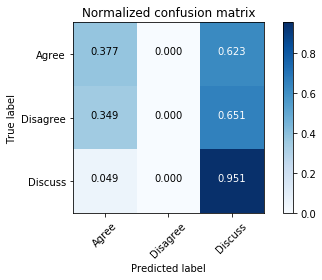

In [120]:
matrix = score_model(predicted_l)
plot_confusion_matrix(matrix, classes=["Agree","Disagree", "Discuss"],
                      title='Normalized confusion matrix')
plt.show()

In [98]:
true_label = [(2 if x[-1] == "agree" else (1 if x[-1] == "discuss" else 0)) for x in stances_val.values]
[list(x) for x in list(confusion_matrix(true_label,predicted_l))]

[[0, 112, 60], [0, 1664, 85], [0, 475, 287]]

In [106]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [99]:
EMBEDDING_DIM = 91
N_FILTERS = 100
FILTER_SIZES = [3,4,5,6,7]
OUTPUT_DIM = 3
DROPOUT = 0.5
# Parameters
num_epochs = 3
batch_size = 250
display_step = 1

model_f = CNN(EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)
optimizer = torch.optim.Adam(model_f.parameters())
criterion = nn.CrossEntropyLoss()

In [100]:
fts = train_feats+val_feats
tr_labels = [str(x[-1]) for x in stances_tr.values]+[str(x[-1]) for x in stances_val.values]

def train_final(model, total_batch, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model_f.train()
    for i in range(total_batch):
        batch_x,batch_y = get_batch(fts, tr_labels,i,batch_size)
        inputs = Variable(torch.FloatTensor(batch_x))
        labels = Variable(torch.LongTensor(batch_y))
        
        optimizer.zero_grad()
        predictions, probs = model(inputs)
        loss = criterion(predictions, labels)
        _, predicted = torch.max(probs.data, 1)
        acc = binary_accuracy(predicted, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / total_batch, epoch_acc / total_batch

In [104]:
batches_train= int(len(fts)/batch_size)

for epoch in range(num_epochs):
    train_loss, train_acc = train_final(model_f, batches_train, optimizer, criterion)
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% |')

| Epoch: 01 | Train Loss: 0.727 | Train Acc: 69.69% |
| Epoch: 02 | Train Loss: 0.555 | Train Acc: 77.40% |
| Epoch: 03 | Train Loss: 0.465 | Train Acc: 80.90% |


In [105]:
torch.save(model_f.state_dict(), './CNN_model_softmax_final.pth')

Normalized confusion matrix
[[0.92857143 0.07142857]
 [0.01388889 0.98611111]]


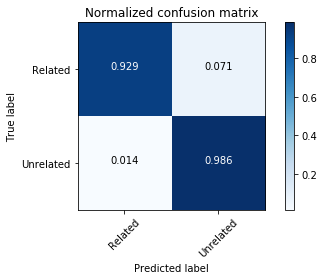

In [122]:
matrix_rel = np.array([[0.26,0.02],[0.01,0.71]])
plot_confusion_matrix(matrix_rel, classes=["Related", "Unrelated"],
                      title='Normalized confusion matrix')
plt.show()